In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-02-20 17:03:30.128932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 17:03:30.312639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 17:03:30.312662: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up 

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [280]:
adata = sc.read('2301_annot_patient_integrated_ambient_removed.h5ad')

In [4]:
pd.crosstab(adata.obs.treatment, adata.obs.patient)

patient               Patient 1  Patient 2  Patient 3  Patient 4
treatment                                                       
BB94                          0          0          0       2625
DMSO                          0          0          0       1541
Gilteritinib                  0          0          0       2590
IFNL                          0          0       3957       3462
IFNa                       3627       5706       3458       3360
IFNa + TNFa                3712          0       5500       2914
IFNg                       3471       4131       4874       3404
IFNg + TGFb2                  0          0       3755       3160
Sorafenib                  3413          0       3943       4417
TGFb2                      3691       3703       4514       3504
TGFb2 + Tirapazamine          0          0       3168       3649
TNFa                       3245       3828       4552       2600
TNFa + IFNg                3354          0       3110       2771
TNFa + TGFb2               2652          0       3546       3101
TNFa + Tirapazamine        4164          0       3693       2460
Tirapazamine               3101       2327       4243       3605
mock                       6752       4888       8687       5732
nan                           0          0      29765      15034

## Calculate categories

Take conditions appearing in all patients:

In [11]:
df = pd.crosstab(adata.obs.treatment, adata.obs.patient)
shared_conds = list(df.index[df.all(axis=1).values])

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


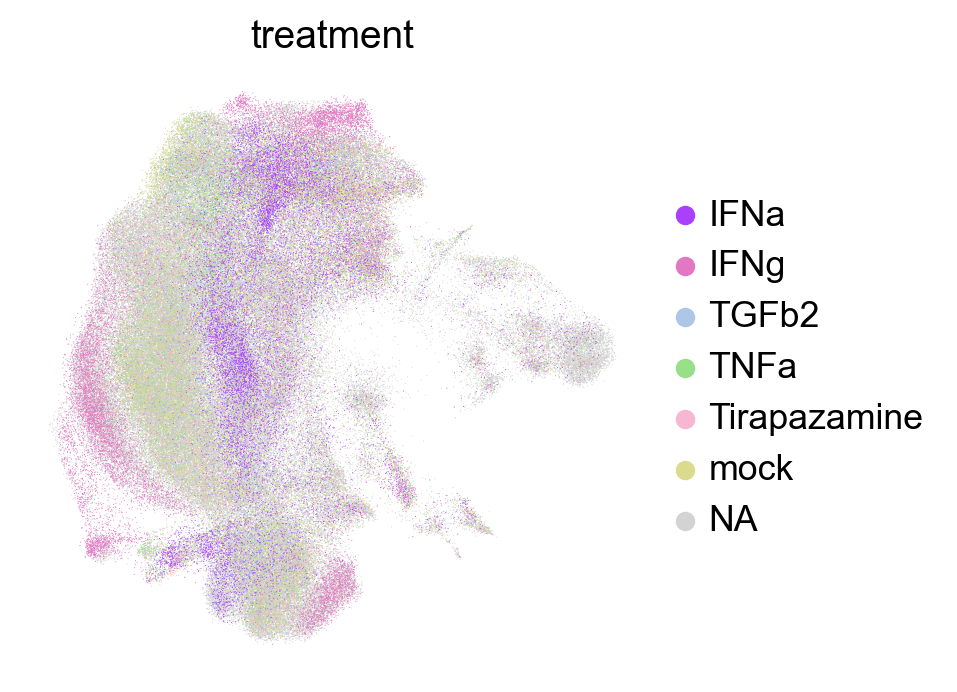

In [38]:
sc.pl.umap(adata, color='treatment', groups=shared_conds)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


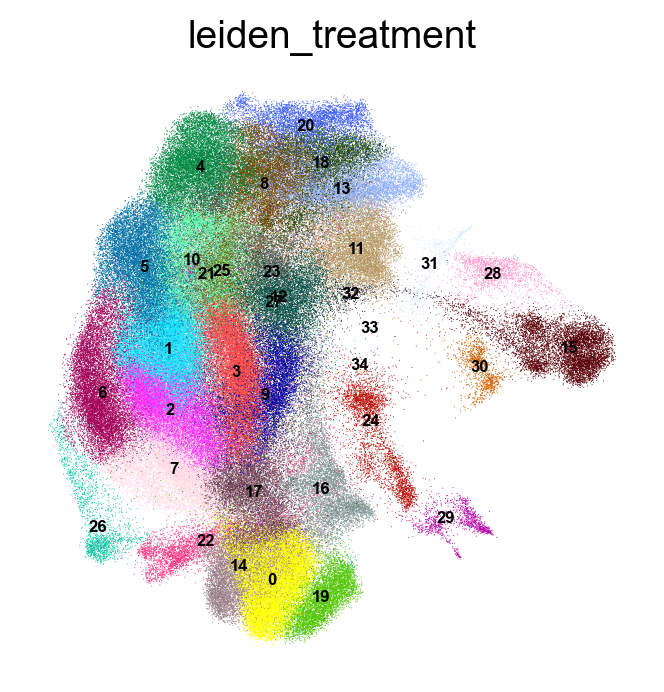

In [142]:
%%time
sc.tl.leiden(adata, resolution=2.5, key_added='leiden_treatment')
sc.pl.umap(adata, color='leiden_treatment', legend_loc='on data', legend_fontsize=6)

Label each leiden cluster with a treatment category.

In [205]:
# get percent nans per cluster and filter out
df = pd.concat([
    pd.DataFrame(adata.obs.leiden_treatment.value_counts()),
    pd.DataFrame(adata[adata.obs.treatment == 'nan'].obs.leiden_treatment.value_counts())
], axis=1).fillna(0)
df.columns = ['total', 'nans']
df['percent_nan'] = df.values[:, 1]/df.values[:, 0]
assign_clusters = df[(df.total > 100) & (df.percent_nan < .30)].index

<AxesSubplot: xlabel='treatment', ylabel='leiden_treatment'>

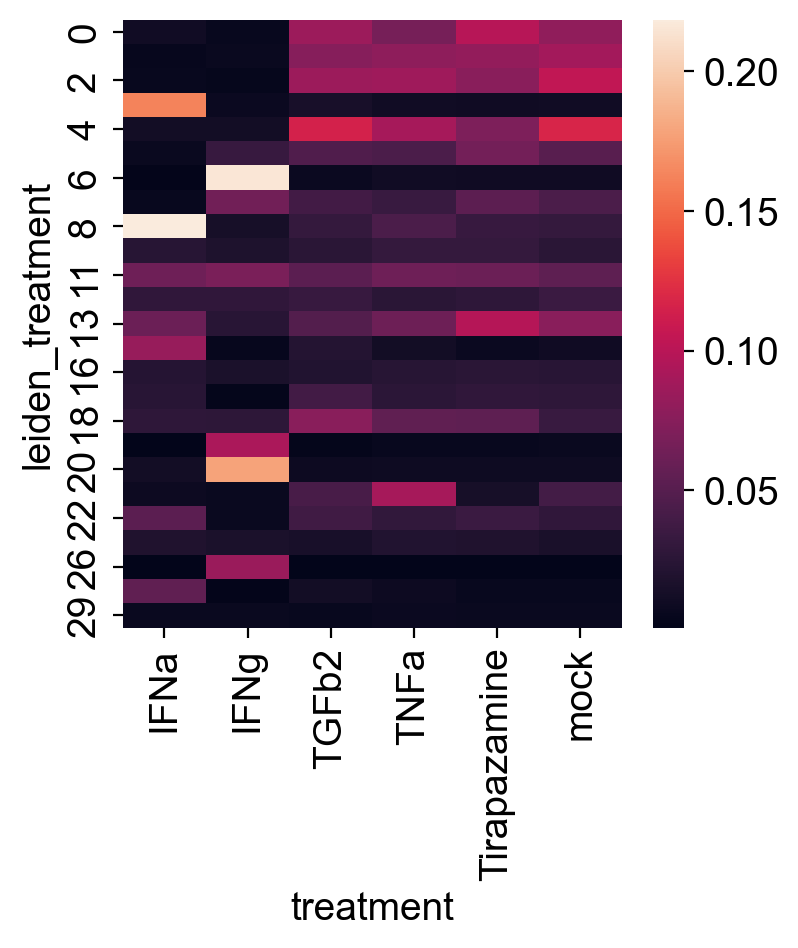

In [206]:
obs_df = pd.crosstab(adata.obs.leiden_treatment, adata.obs.treatment)
obs_df /= obs_df.sum(axis=0)
sns.heatmap(obs_df.T[assign_clusters].T[shared_conds])

There are some clusters that clearly belong to a condition and otherwise it's unclear. Only assign a cluster a category if it's significantly enriched with a condition.

In [240]:
signif_thresh = 2
assign_dict = {}
for c in adata.obs.leiden_treatment.cat.categories:
    if c not in assign_clusters:  # ones with too many nans
        pass
#         assign_dict[c] = 'no_category'
    else:
        n_large = obs_df[shared_conds].T[c].nlargest(2)
        if n_large[0] > n_large[1]*signif_thresh:
            assign_dict[c] = n_large.index[0]
        else:
            assign_dict[c] = 'mock'
            
adata.obs['trt_category'] = adata.obs.leiden_treatment.map(assign_dict)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


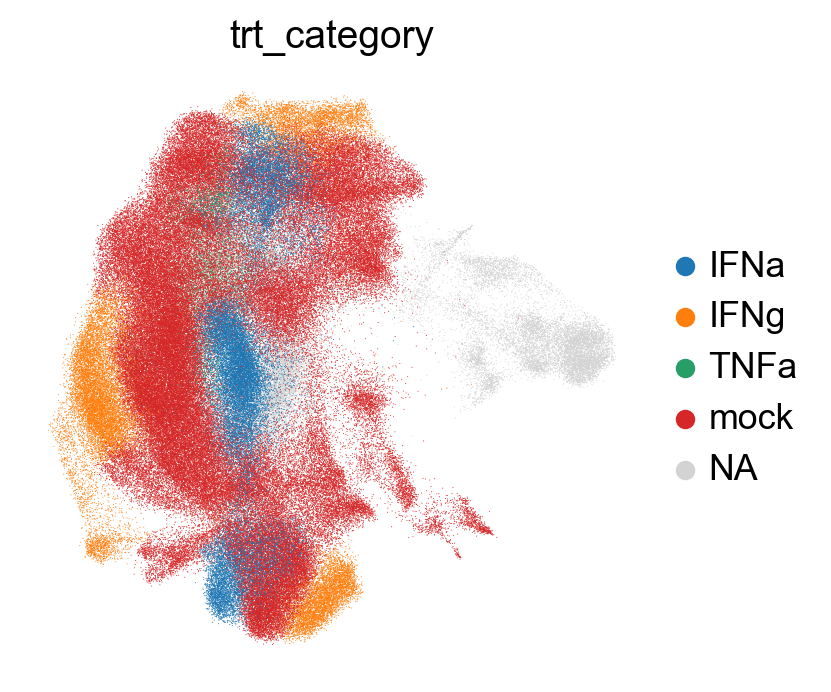

In [241]:
sc.pl.umap(adata, color='trt_category')

Check assignment:

In [242]:
pd.crosstab(adata.obs.trt_category, adata.obs.treatment)[shared_conds]

treatment     IFNa  IFNg  TGFb2   TNFa  Tirapazamine   mock
trt_category                                               
IFNa          8390   449   1209   1052           742   1482
IFNg           258  9079    310    381           332    682
TNFa           136   103    654   1290           184   1027
mock          6007  5368  12267  10554         11029  21151

Re-categorize all treatments by representation in treatment category.

In [283]:
df = pd.crosstab(adata.obs.trt_category, adata.obs.treatment)
adata.obs['trt_category'] = adata.obs.treatment.map(dict(df.idxmax()))
# store mapping as dictionary
adata.uns['trt_categories'] = adata.obs[['trt_category', 'treatment']].groupby('treatment').first().reset_index().groupby('trt_category').agg(list).to_dict()['treatment']

adata.obs[['trt_category', 'treatment']].groupby('treatment').first().sort_values('trt_category')

trt_category
treatment                        
IFNL                         IFNa
IFNa                         IFNa
IFNa + TNFa                  IFNa
IFNg                         IFNg
IFNg + TGFb2                 IFNg
TNFa + IFNg                  IFNg
BB94                         mock
Tirapazamine                 mock
TNFa + Tirapazamine          mock
TNFa + TGFb2                 mock
TNFa                         mock
Sorafenib                    mock
TGFb2                        mock
mock                         mock
Gilteritinib                 mock
DMSO                         mock
TGFb2 + Tirapazamine         mock
nan                          mock

In [285]:
adata.write('2301_annot_patient_integrated_ambient_removed.h5ad')

## Take significant DEGs between categories

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


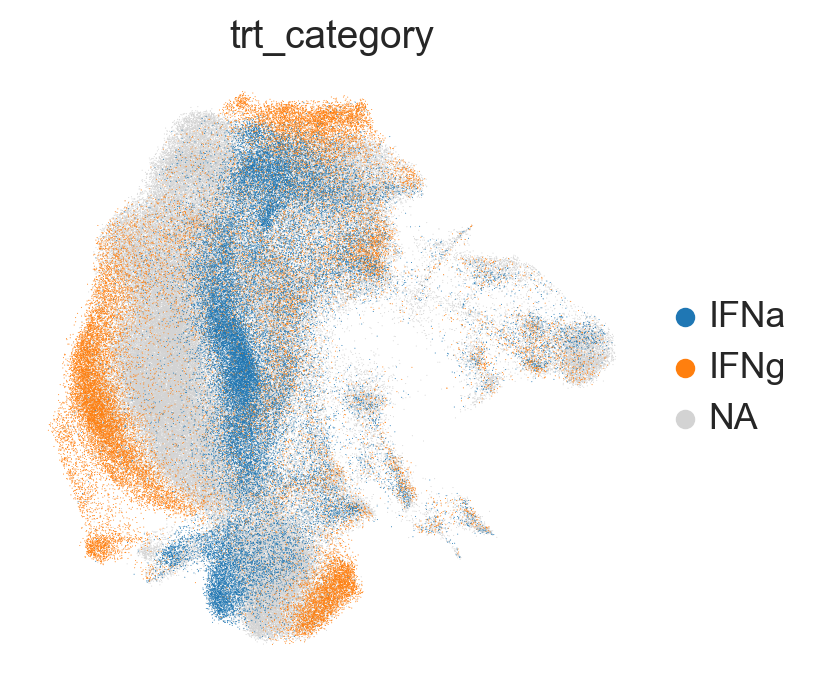

In [284]:
sc.pl.umap(adata, color='trt_category', groups=['IFNa', 'IFNg'])

In [324]:
adata.uns['trt_categories']

{'IFNa': ['IFNL', 'IFNa', 'IFNa + TNFa'],
 'IFNg': ['IFNg', 'IFNg + TGFb2', 'TNFa + IFNg'],
 'mock': ['BB94',
  'DMSO',
  'Gilteritinib',
  'Sorafenib',
  'TGFb2',
  'TGFb2 + Tirapazamine',
  'TNFa',
  'TNFa + TGFb2',
  'TNFa + Tirapazamine',
  'Tirapazamine',
  'mock',
  'nan']}

In [ ]:
from utils import enrich

In [331]:
def plot_volcano(df, fc_thresh=2, logpval_thresh=50, plot=True):
    """Make a volcano plot from a rank_genes_groups dataframe.
    
    Returns
    -------
    df
        Modified dataframe with plot values.
    up_genes
        Genes with significantly increased differential expression.
    down_genes
        Genes with significantly decreased differential expression.
    """
    df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
    df = df.replace(np.inf, 325)
    sig_up = df[(df['logfoldchanges'] > fc_thresh) & (df['-log10(pvals)'] > logpval_thresh)].copy()
    sig_down = df[(df['logfoldchanges'] < -fc_thresh) & (df['-log10(pvals)'] > logpval_thresh)].copy()

    if plot:
        # grey - not significant
        plt.scatter(df['logfoldchanges'].values, df['-log10(pvals)'].values, s=4, c='grey')
        # red - up and significant
        plt.scatter(sig_up['logfoldchanges'].values, sig_up['-log10(pvals)'].values, s=4, c='darkred')
        # blue - down and significant
        plt.scatter(sig_down['logfoldchanges'].values, sig_down['-log10(pvals)'].values, s=4)

        plt.xlabel('logFC')
        plt.ylabel('-log10(pvals)')
        plt.xlim(-7, 7)  # to avoid plotting super high FC genes caused by dropout
    return df, sig_up.names.values, sig_down.names.values

In [287]:
sc.tl.rank_genes_groups(adata, agroupby='trt_category', reference='mock')

/tmp/ipykernel_3880185/2747907373.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


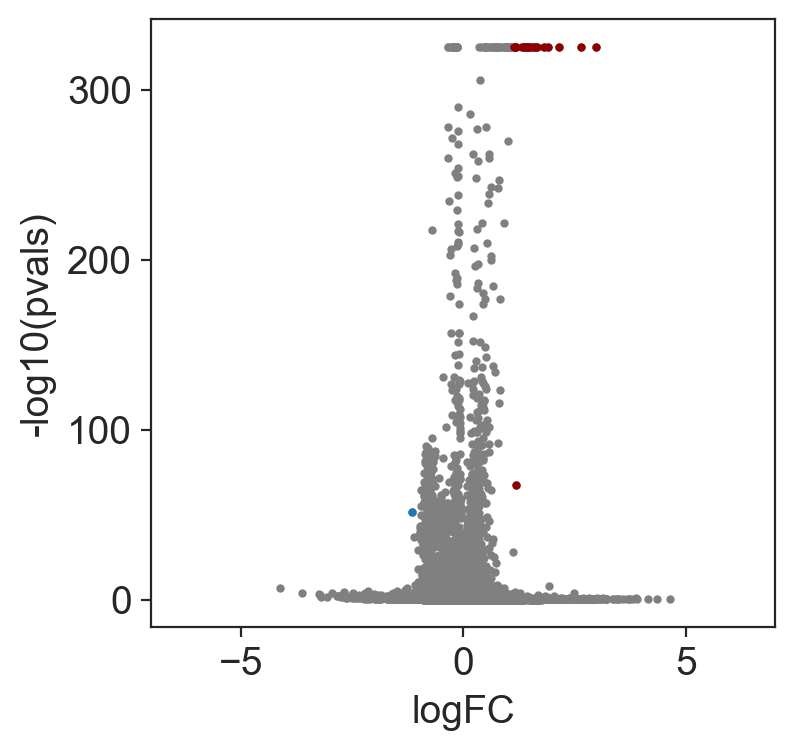

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


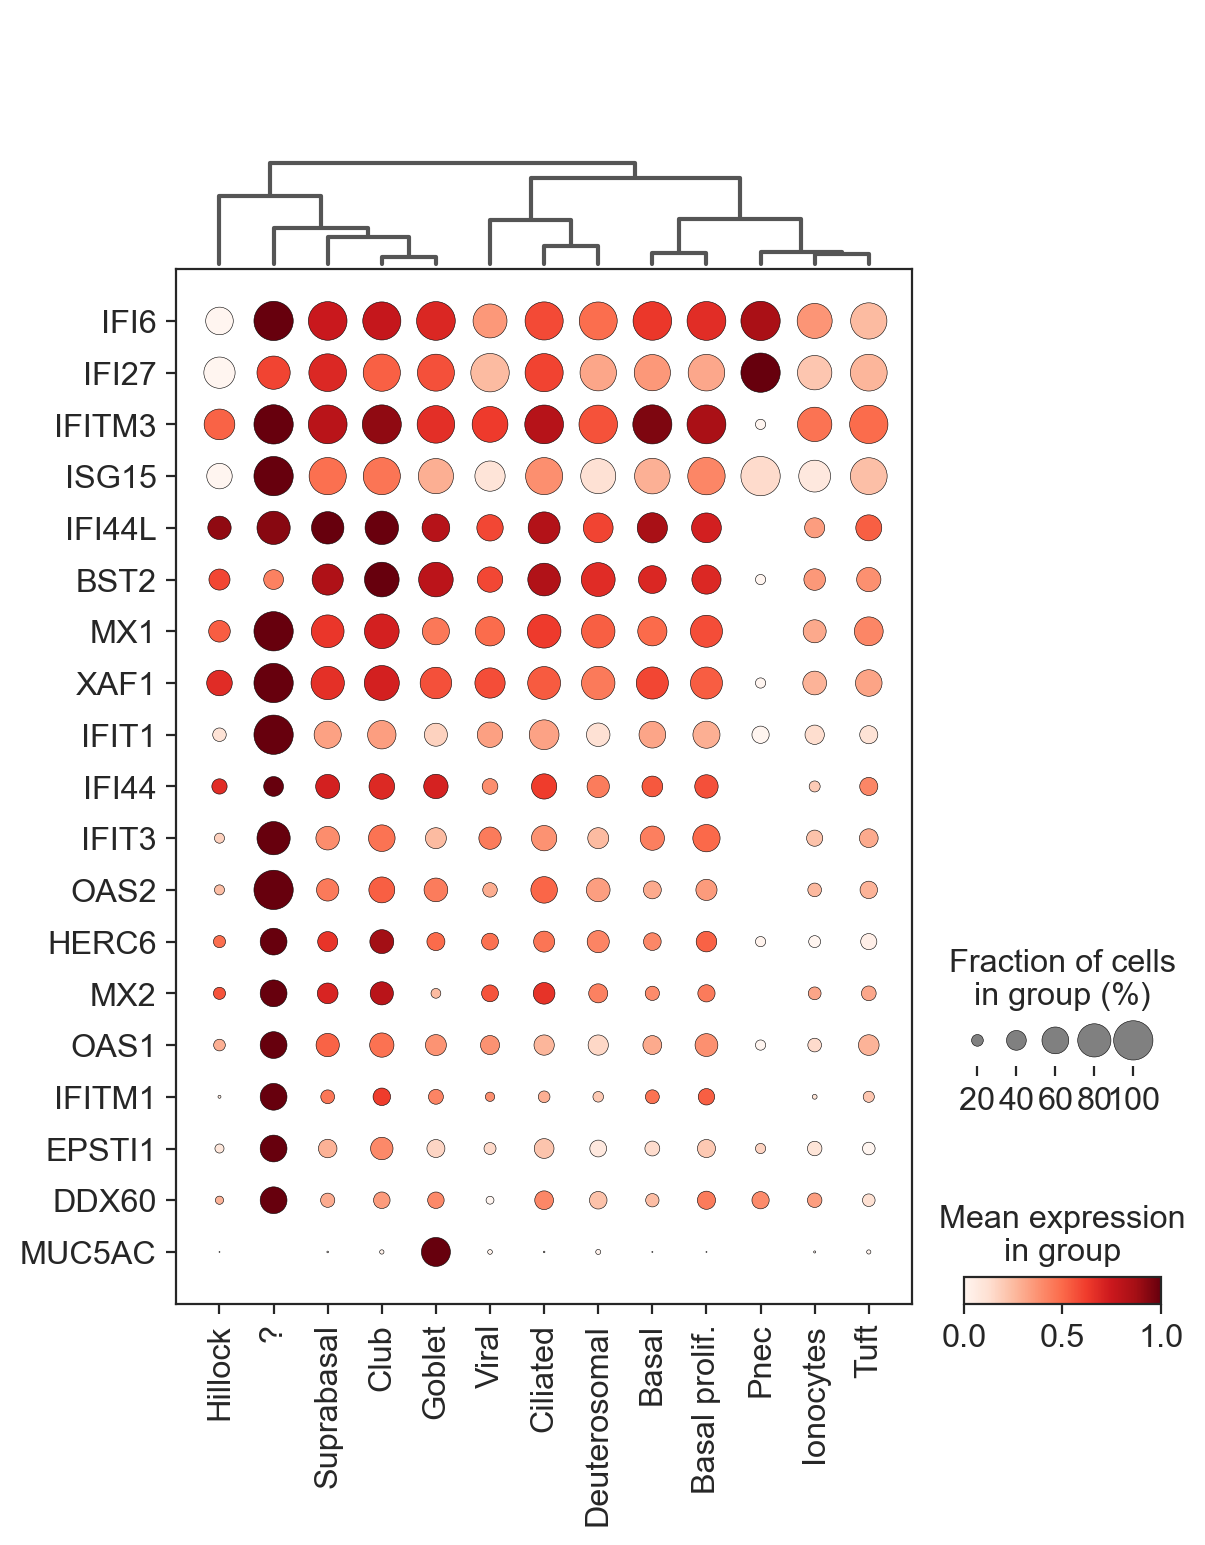

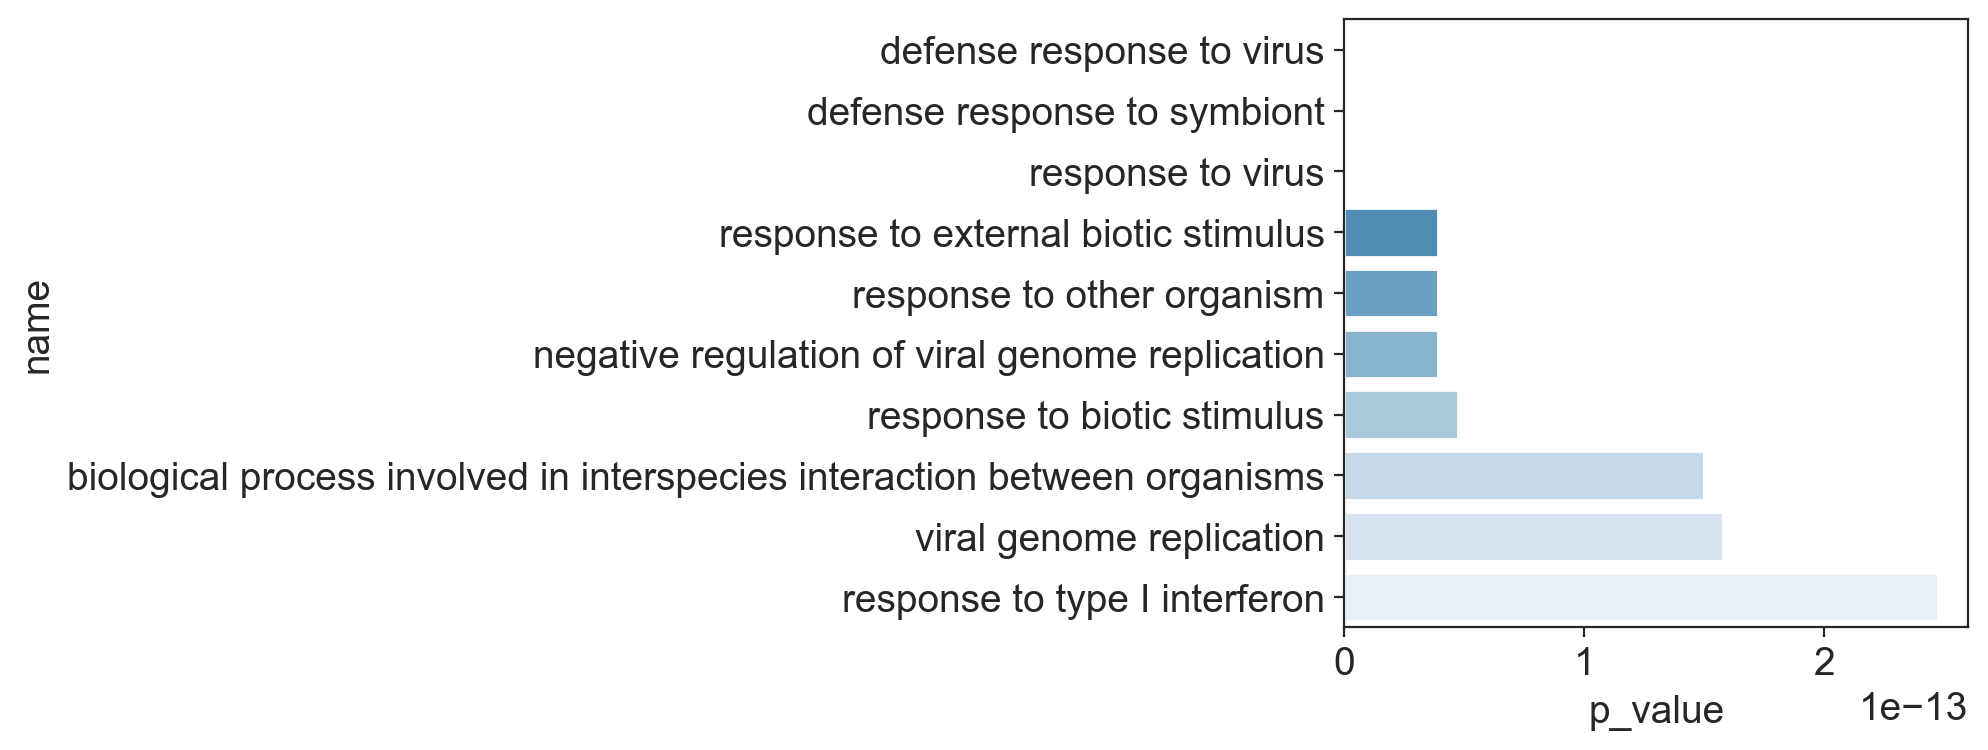

/tmp/ipykernel_3880185/2747907373.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


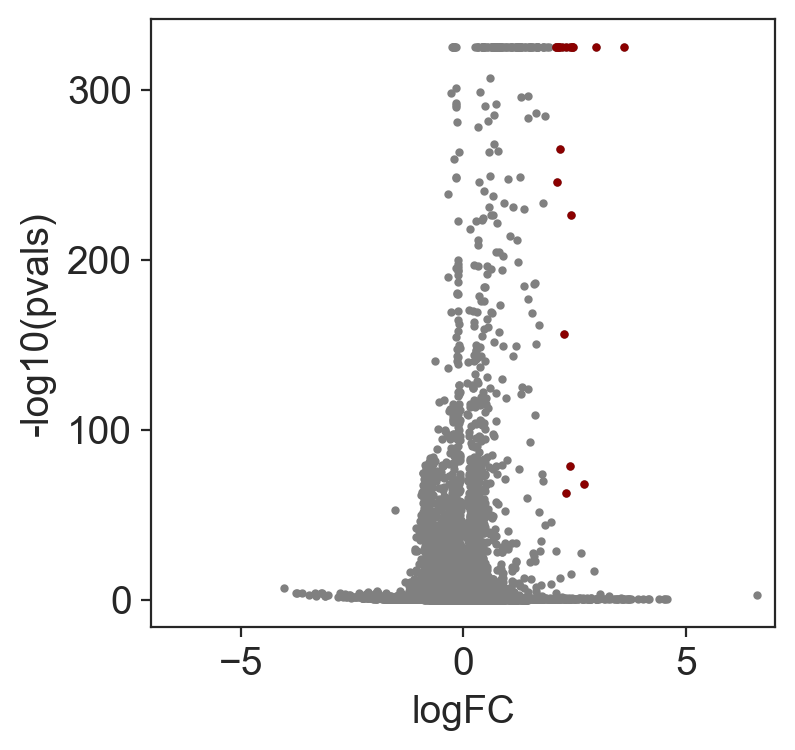

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


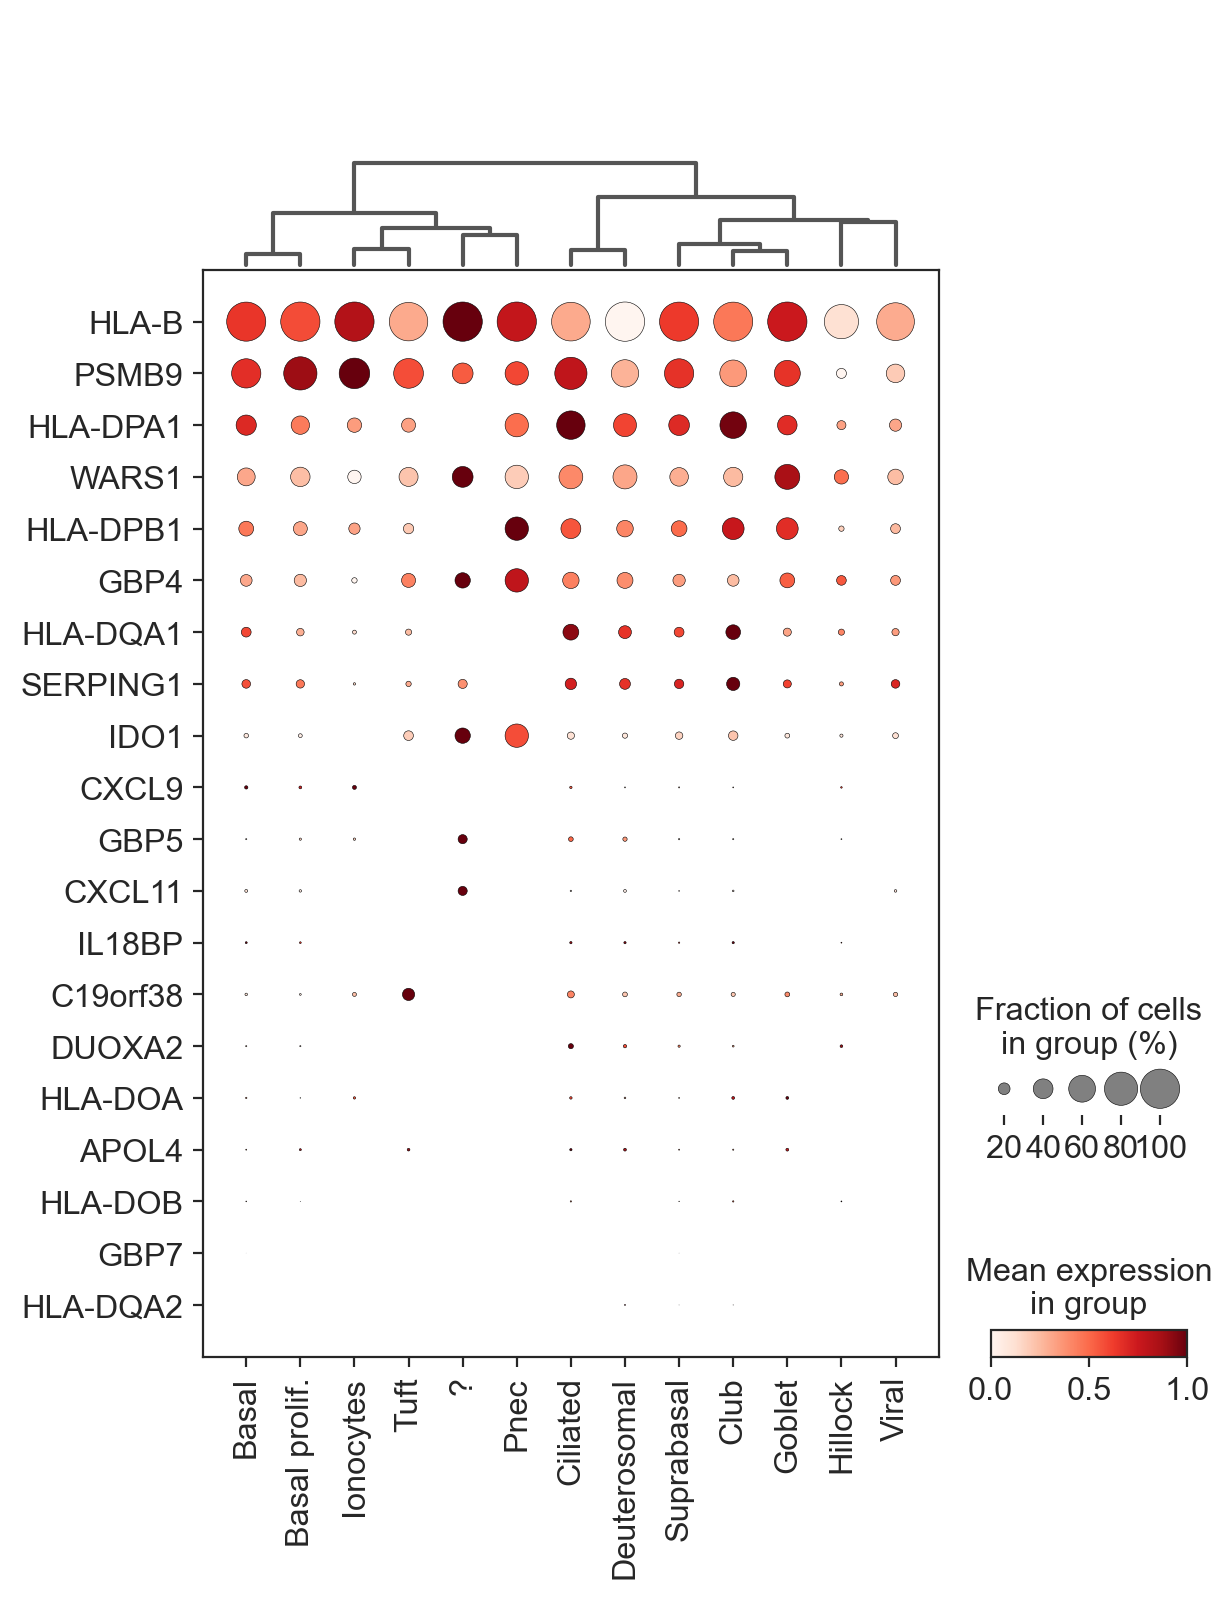

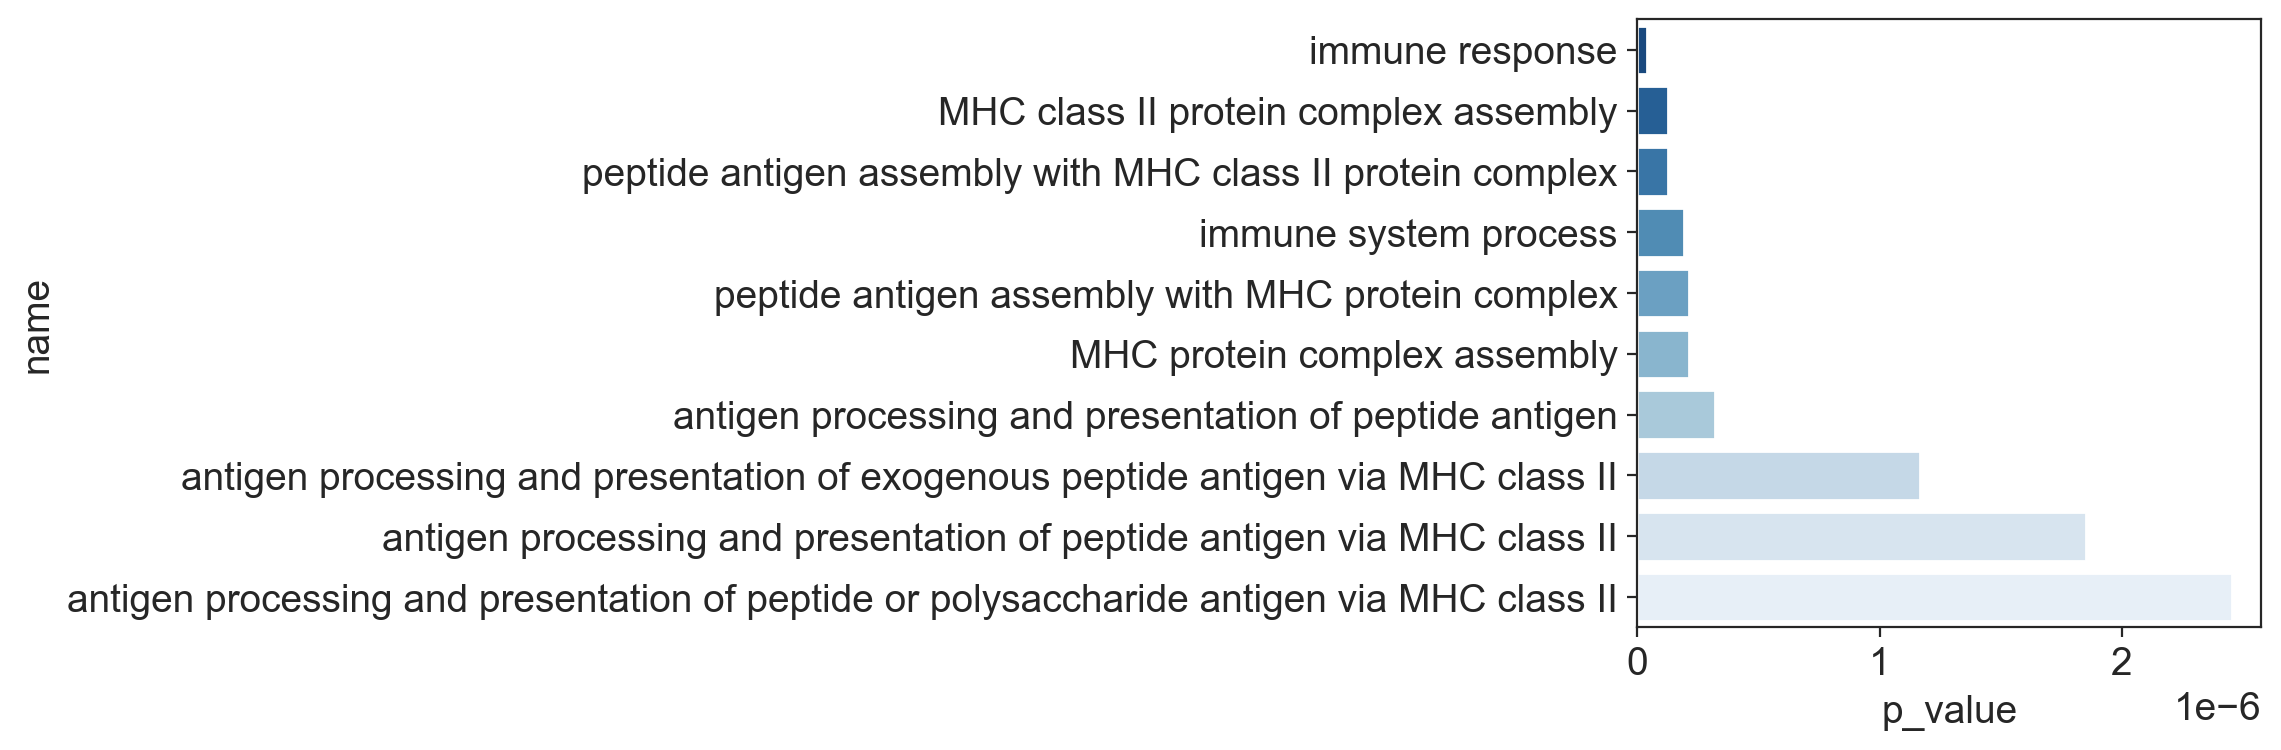

In [325]:
for cat, thresh in zip(['IFNa', 'IFNg'], [1.1, 2]):
    df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(adata, group=cat), fc_thresh=thresh)
    plt.show()

#     for trt in adata.uns['trt_categories'][cat]:
#         sc.pl.dotplot(adata[adata.obs.treatment == trt], var_names=up, groupby='cell_type', standard_scale='var', title=trt)

    sc.pl.dotplot(
        adata[(adata.obs.treatment.isin(adata.uns['trt_categories'][cat])) & (adata.obs.patient.isin(['Patient 3', 'Patient 4']))],
        var_names=up, groupby='cell_type', standard_scale='var', swap_axes=True, dendrogram=True
    )

    sns.barplot(data=enrich(up, adata.var_names).head(10), x='p_value', y='name', palette='Blues_r')
    plt.show()

Calculate DEGs per cell type (if there are any):

In [335]:
for ct in adata.obs.cell_type.cat.categories:
    subset = adata[adata.obs.cell_type == ct]
    sc.tl.rank_genes_groups(subset, groupby='trt_category', reference='mock')
    for cat in ['IFNa', 'IFNg']:
        df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(subset, group=cat), fc_thresh=2, plot=False)
#         plt.title(cat)
#         plt.show()
        if len(up) + len(dn) > 5:
            print(ct, cat, len(up)+len(dn), up)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Basal IFNg 23 ['HLA-B' 'CD74' 'HLA-DRA' 'PSMB9' 'HLA-DRB1' 'HLA-F' 'HLA-DPA1' 'HLA-DQB1'
 'HLA-DPB1' 'WARS1' 'HLA-DQA1' 'GBP4' 'SERPING1' 'HLA-DMB' 'IDO1' 'CXCL9'
 'CXCL11' 'GBP5' 'CXCL10' 'IL18BP' 'APOL3' 'HLA-DRB5' 'BATF2']


/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Basal prolif. IFNa 8 ['IFI6' 'IFI27' 'ISG15' 'MX1' 'IFI44L' 'IFIT1' 'IFIT3' 'BST2']


/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Club IFNg 19 ['WARS1' 'PSMB9' 'HLA-DPA1' 'IDO1' 'HLA-DPB1' 'TAP1' 'HLA-DQA1' 'SERPING1'
 'GBP4' 'CXCL9' 'GBP5' 'CXCL11' 'IL18BP' 'HLA-DOA' 'C19orf38' 'DUOXA2'
 'TF' 'APOL4' 'HLA-DQA2']


/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Suprabasal IFNa 17 ['IFI6' 'IFI27' 'ISG15' 'IFI44L' 'XAF1' 'MX1' 'BST2' 'IFIT1' 'IFIT3'
 'OAS2' 'MX2' 'HERC6' 'EPSTI1' 'IFITM1' 'RSAD2' 'CMPK2' 'HERC5']
Suprabasal IFNg 22 ['B2M' 'HLA-B' 'HLA-C' 'CD74' 'HLA-DRA' 'PSMB9' 'HLA-DRB1' 'HLA-F' 'IRF1'
 'HLA-DPA1' 'HLA-DPB1' 'WARS1' 'HLA-DQA1' 'GBP4' 'SERPING1' 'IDO1' 'CXCL9'
 'C19orf38' 'DUOXA2' 'GBP5' 'CXCL10' 'CXCL11']


/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/tmp/ipykernel_3880185/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


### examine individual treatments not included bc they need lower thresholding for less effect

In [353]:
subset = adata[adata.obs.patient.isin(['Patient 1', 'Patient 2'])]
sc.tl.rank_genes_groups(subset, groupby='treatment', reference='mock')

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [359]:
enrich(up, subset.var_names).head(10)

Empty DataFrame
Columns: [name, p_value, intersections]
Index: []

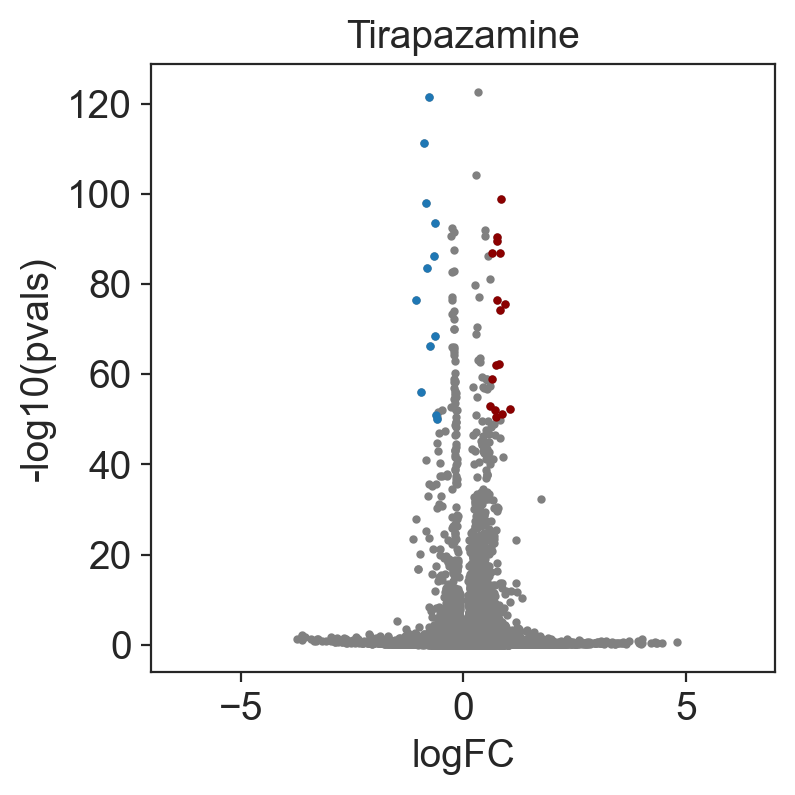

['ISG15' 'MX1' 'IFI6' 'IFIT3' 'C15orf48' 'IFI44L' 'IFIT2' 'IFIT1' 'MX2'
 'CST6' 'IFI27' 'SAMD9' 'HERC5' 'OAS3' 'CMPK2' 'IFIH1']


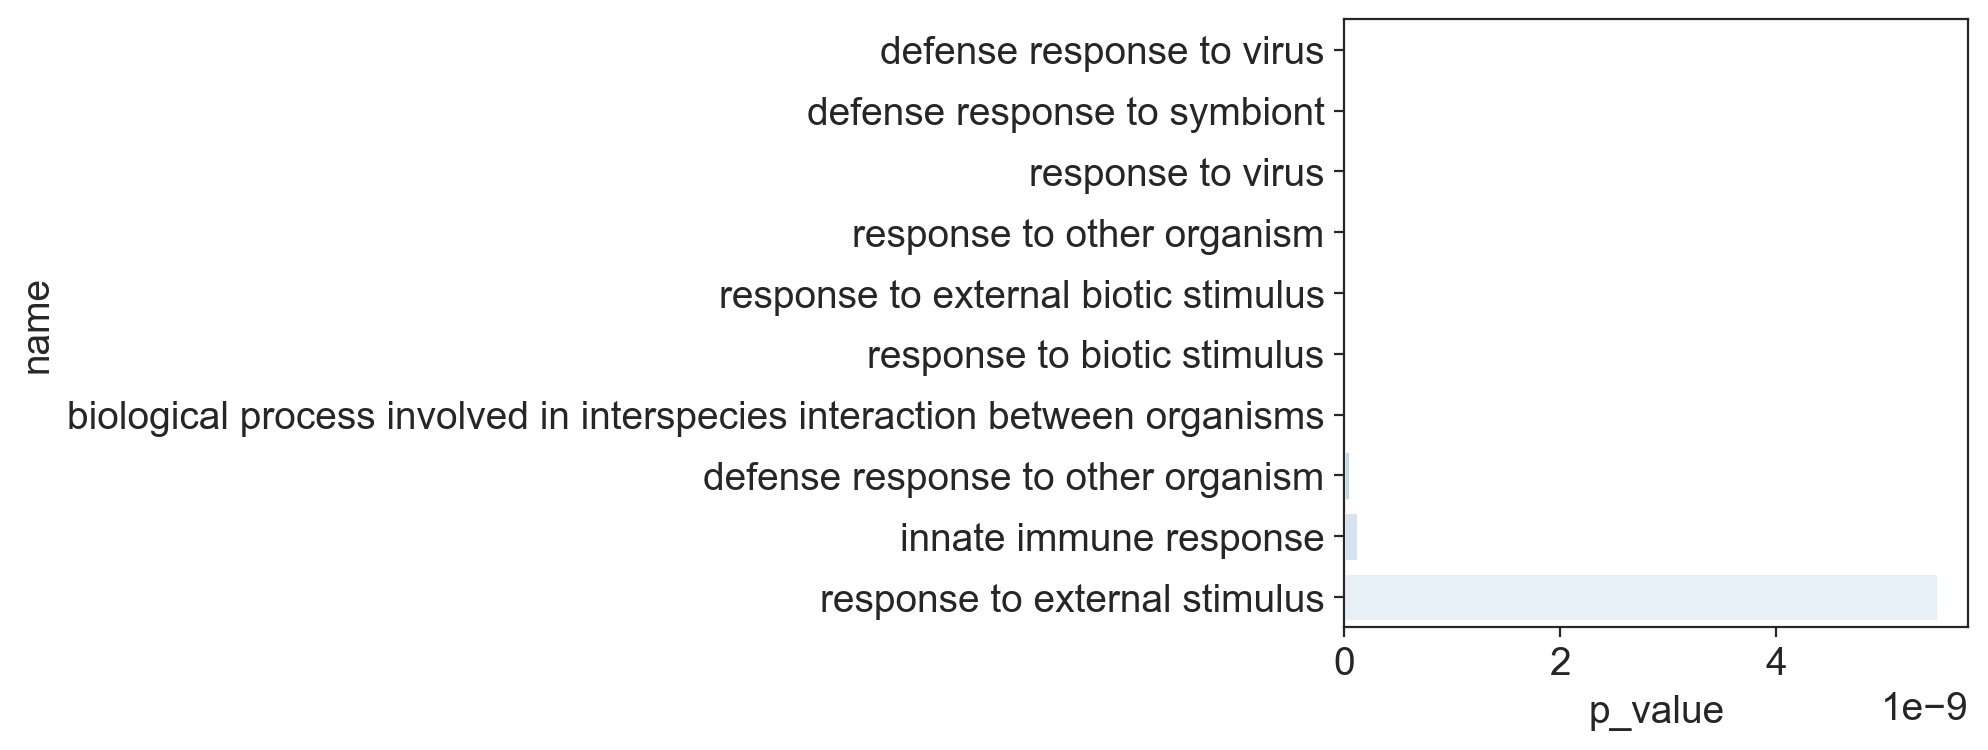

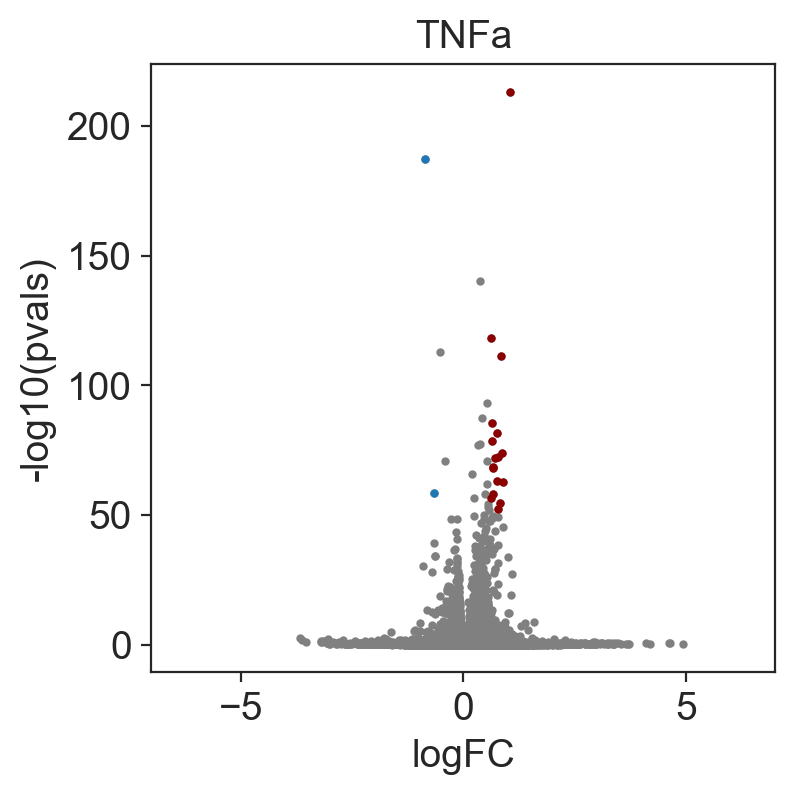

['TNFAIP2' 'SLC34A2' 'MSMB' 'BST2' 'IFIT3' 'MX1' 'IFIT2' 'IFIT1' 'OAS1'
 'ISG15' 'IFI44L' 'MX2' 'CXCL10' 'PI3' 'LYPD2' 'OASL' 'RSAD2']


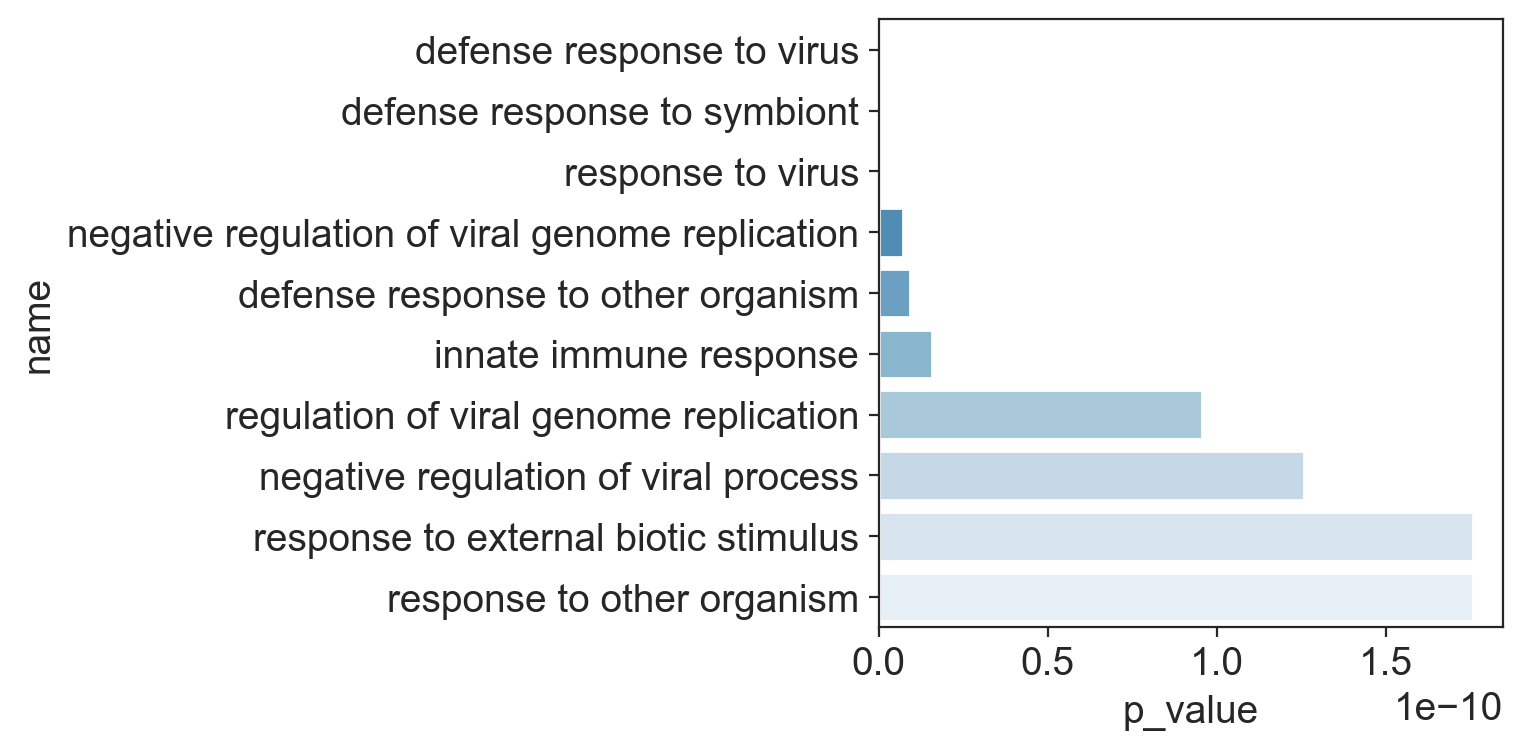

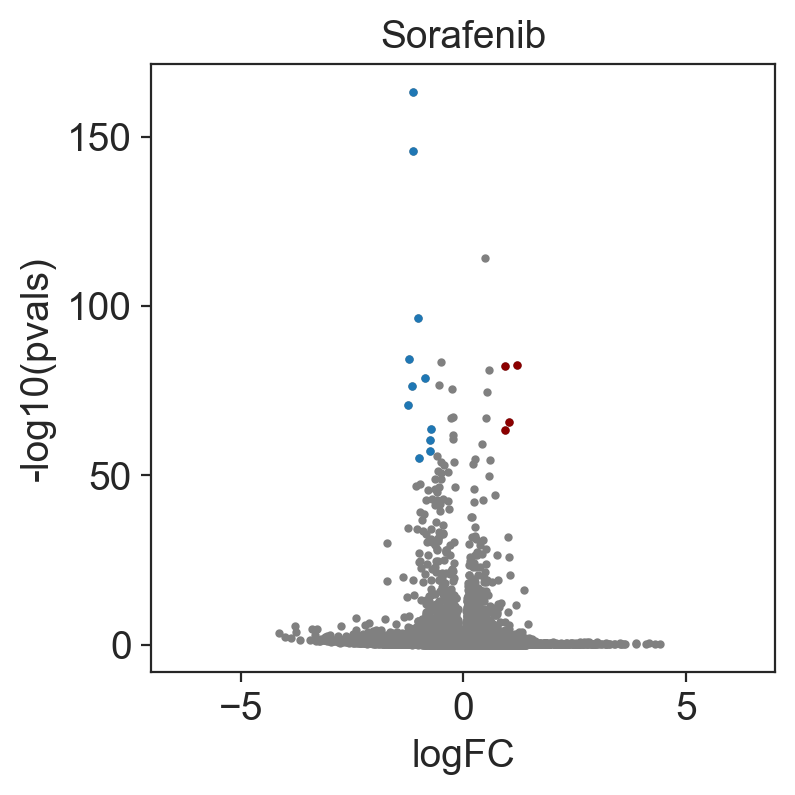

['DUSP6' 'VPS13D' 'CYP1B1' 'EGR1']


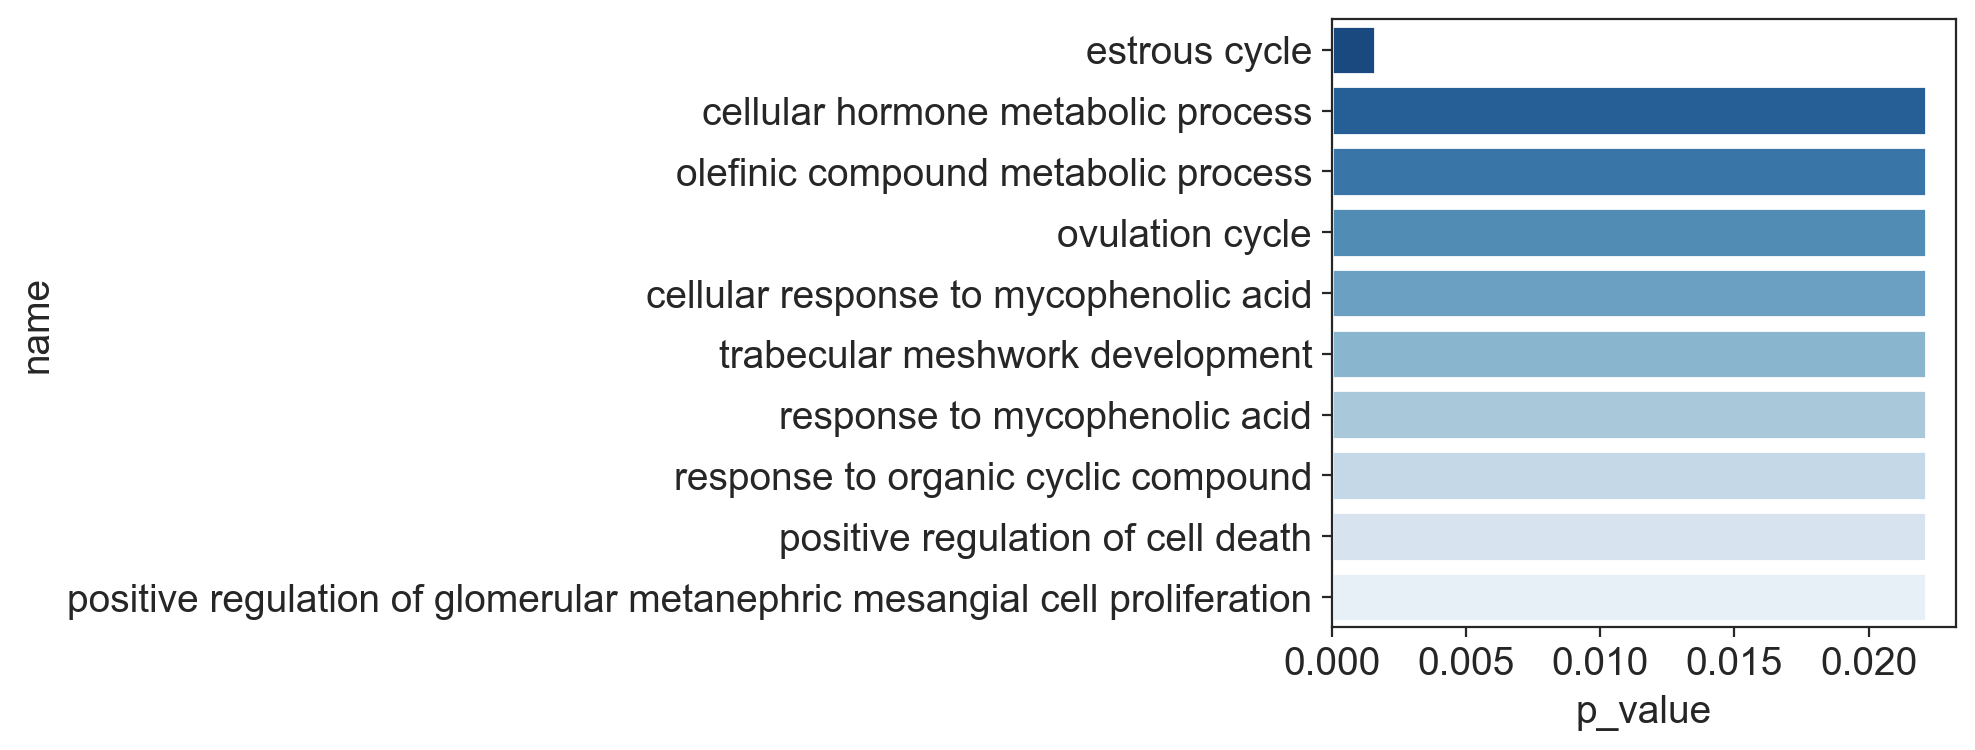

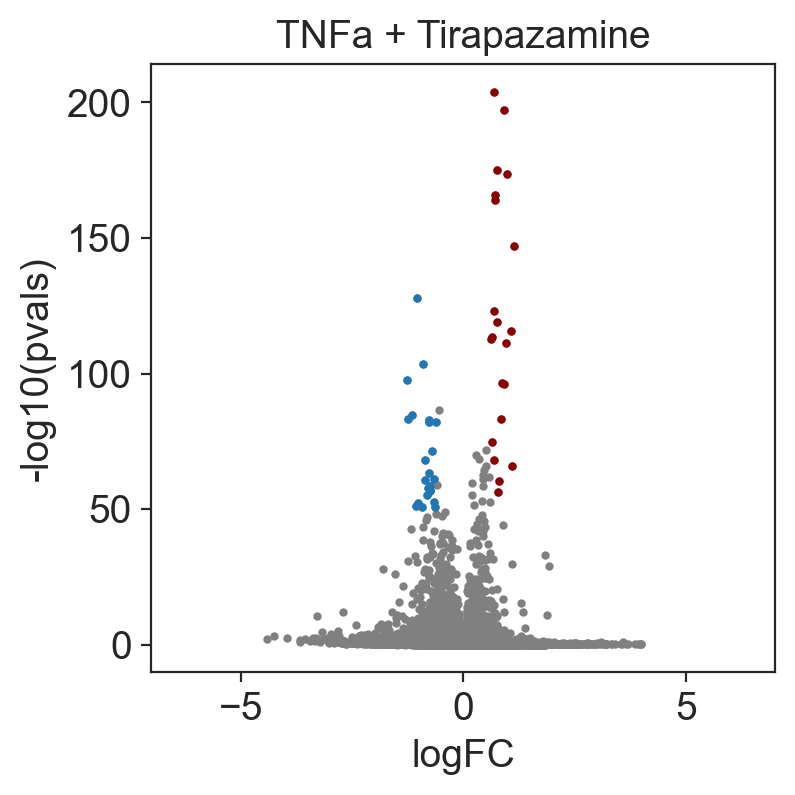

['CD74' 'SLC34A2' 'HLA-DRB1' 'CAPN13' 'HLA-DRA' 'CXCL8' 'MSMB' 'CP' 'VMO1'
 'BPIFA1' 'TMEM45A' 'RARRES1' 'BPIFB1' 'TNFAIP2' 'LYPD2' 'MUC5B' 'SGPP2'
 'HLA-DQB1' 'FMO2' 'WNT4' 'HLA-DQA1']


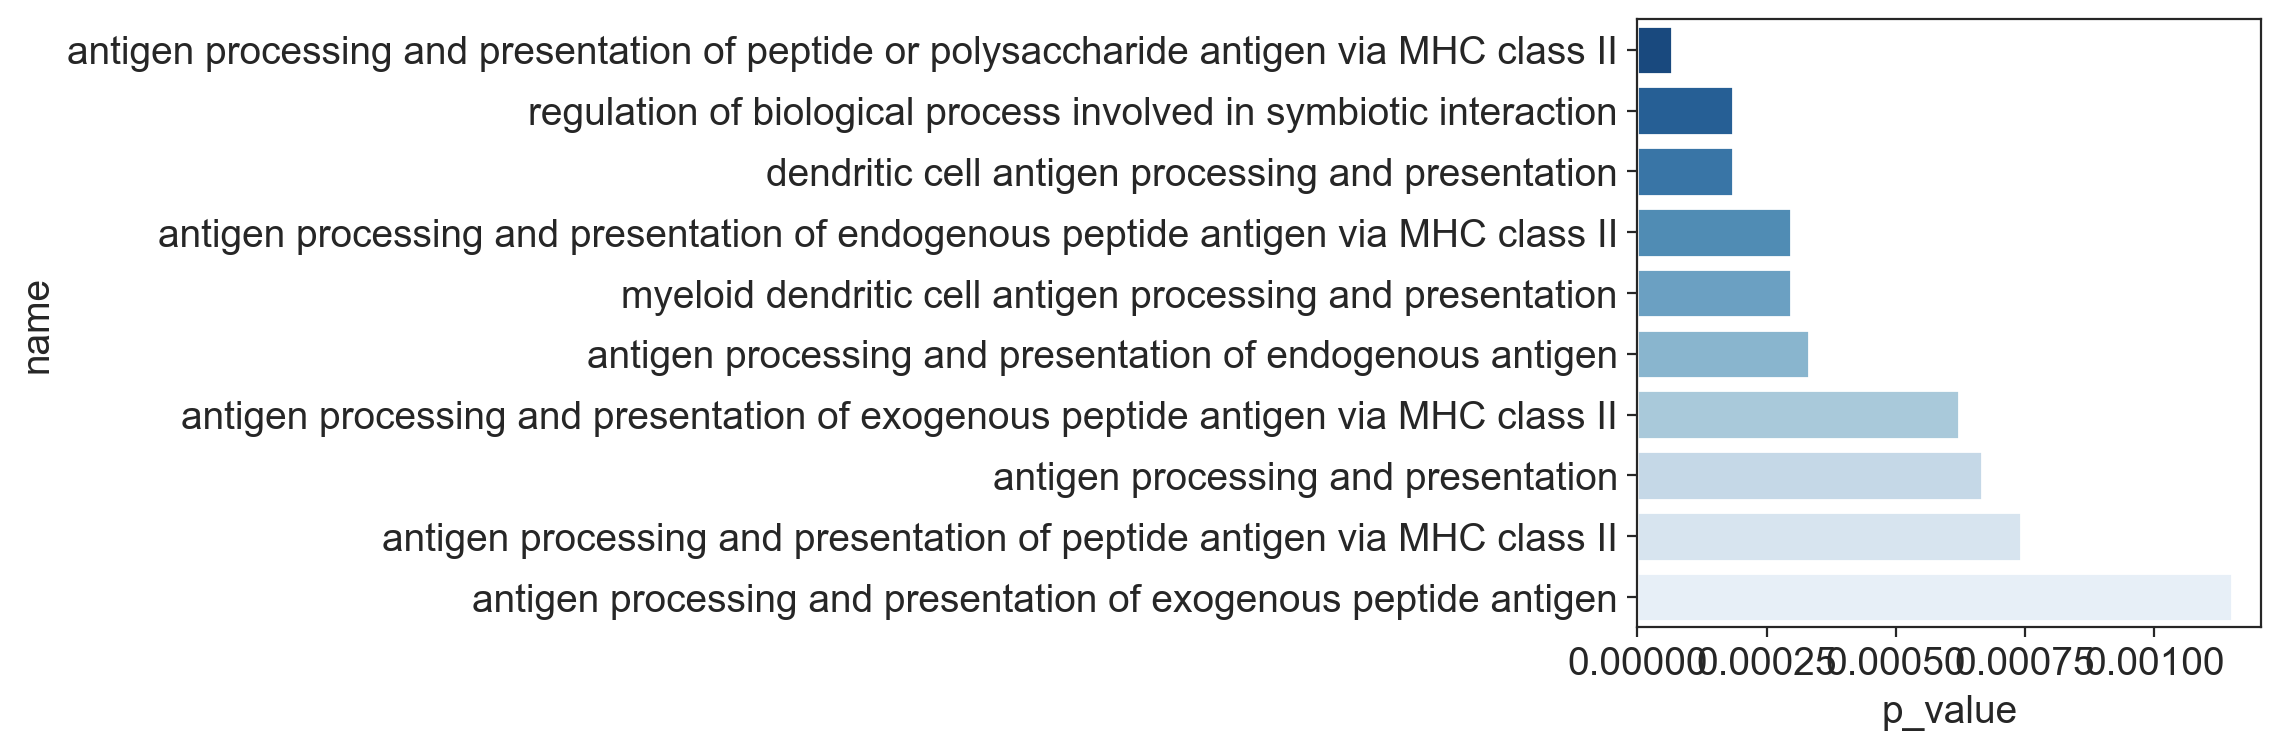

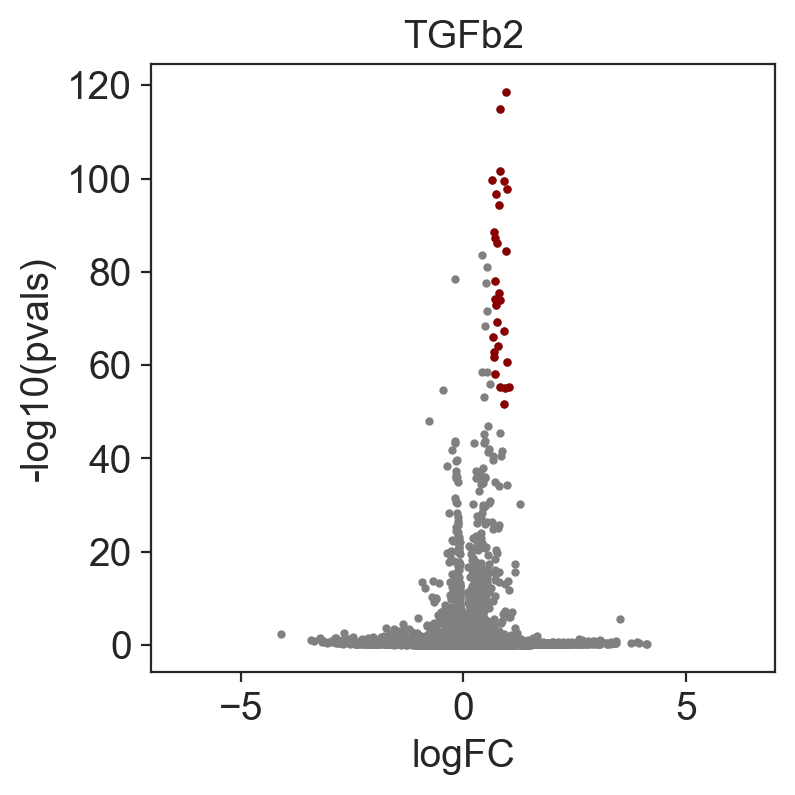

['IFIT1' 'SAMD9' 'ISG15' 'ISG20' 'MX2' 'IFIT2' 'MX1' 'IFIT3' 'BST2' 'IFI6'
 'OAS1' 'RSAD2' 'IFI35' 'OAS3' 'NT5C3A' 'IFITM1' 'EPSTI1' 'OAS2' 'OASL'
 'XAF1' 'DDX58' 'IRF7' 'SAMD9L' 'HERC5' 'IFIH1' 'CEACAM5' 'CMPK2' 'DDX60L'
 'TNFSF13B']


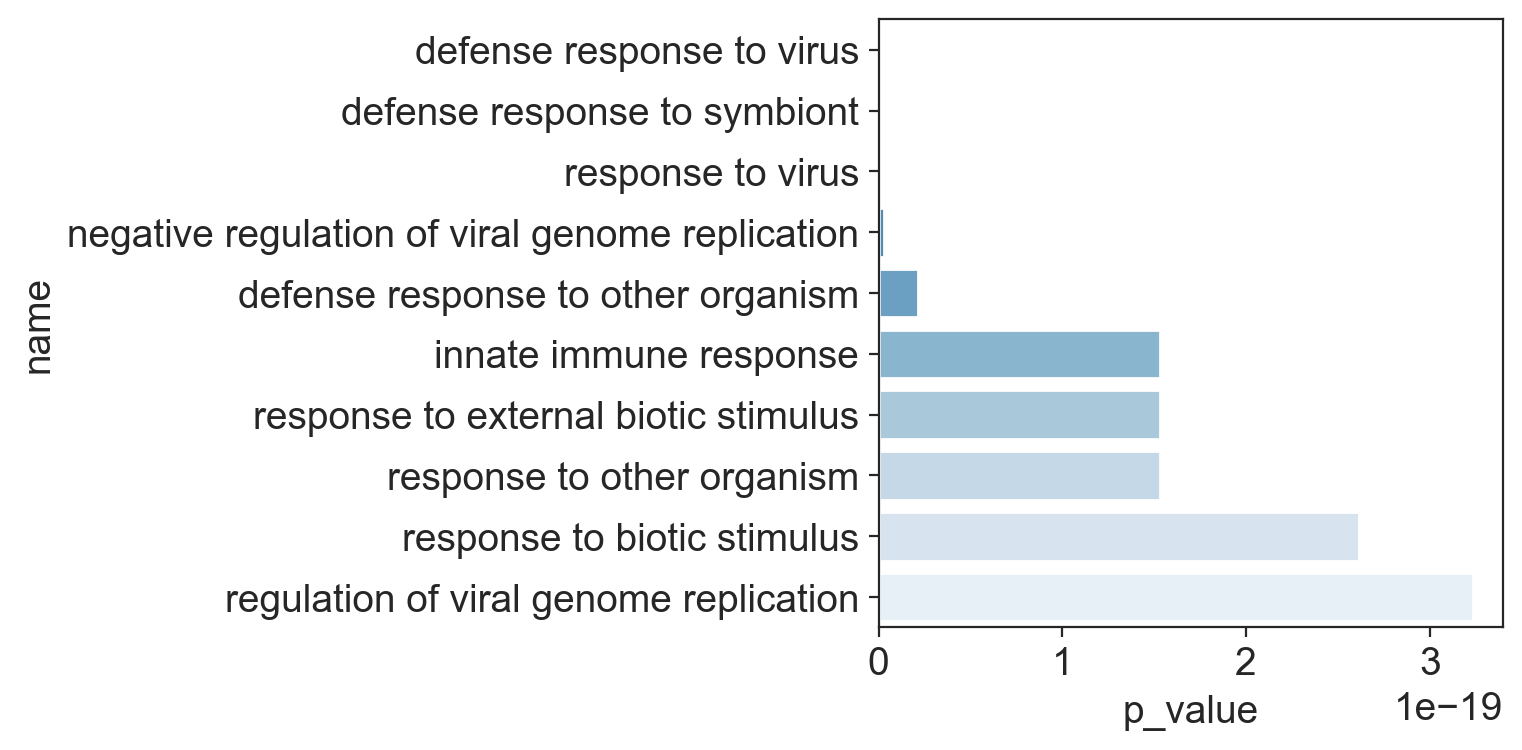

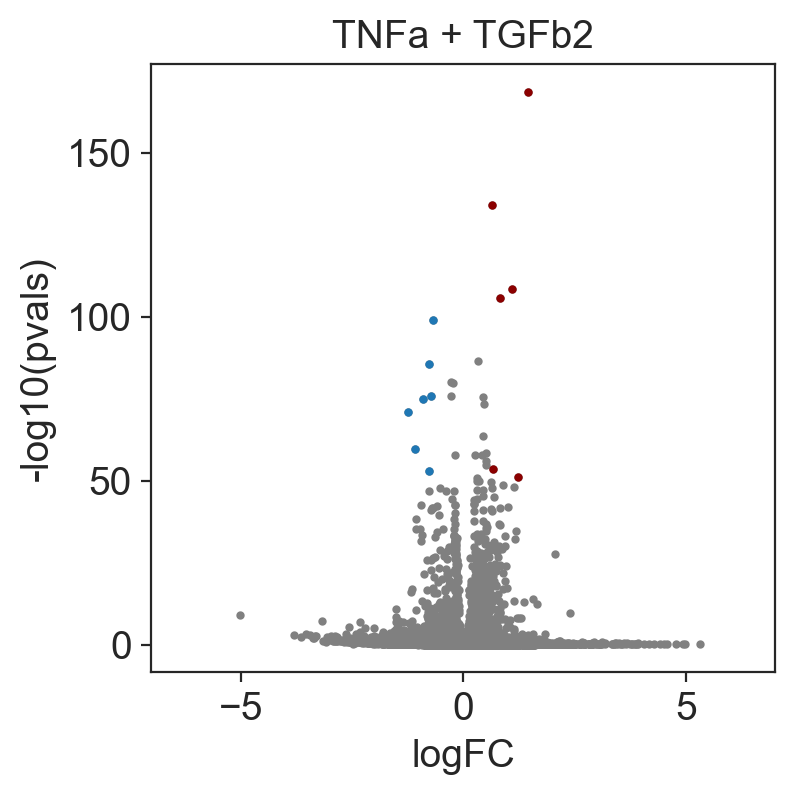

['MMP7' 'KRT17' 'IL32' 'SLC34A2' 'C15orf48' 'CXCL10']


ValueError: min() arg is an empty sequence

In [358]:
for trt in subset.obs.treatment.unique():
    if trt == 'mock' or trt in adata.uns['trt_categories']['IFNg'] or trt in adata.uns['trt_categories']['IFNa']:
        continue
    df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(subset, group=trt), fc_thresh=.6, logpval_thresh=50)
    plt.title(trt)
    plt.show()

    diff_genes = list(up) + list(dn)
    if len(diff_genes) > 10:
#         sc.pl.dotplot(subset, groupby='cell_type', var_names=diff_genes, standard_scale='var', swap_axes=True)
        print(up)
        try:
            sns.barplot(data=enrich(up, subset.var_names).head(10), x='p_value', y='name', palette='Blues_r')
            plt.show()
        except ValueError:  # no pathways
            pass